# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [118]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm
import patsy

from sklearn import metrics

%matplotlib inline

In [86]:
df = pd.read_csv('previsao_de_renda.csv')

In [87]:
df.drop(columns = ['Unnamed: 0','data_ref','id_cliente'],inplace = True)
df.dropna(axis=0,inplace=True)

In [88]:
df.dropna(axis=0,inplace=True)

In [89]:
df_raw = df
df_raw

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97
...,...,...,...,...,...,...,...,...,...,...,...,...
14994,M,True,False,0,Empresário,Superior incompleto,Casado,Casa,32,9.849315,2.0,1592.57
14995,F,False,True,0,Empresário,Secundário,Solteiro,Casa,48,13.887671,1.0,7990.58
14997,F,True,True,0,Assalariado,Superior completo,Casado,Casa,45,7.832877,2.0,604.82
14998,M,True,False,0,Empresário,Superior completo,Casado,Casa,36,4.298630,2.0,3352.27


1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.

### 1. Separando dados em treino e teste

In [90]:
from sklearn.model_selection import train_test_split

In [154]:
df = pd.get_dummies(df,drop_first=True)

colunas = []
for i in df.columns:
    colunas.append(i.replace(' ', '_'))
df.columns = colunas

X = df.drop(axis=1,columns=['renda'])
y = df.renda

X.posse_de_imovel = X.posse_de_imovel.astype(int)
X.posse_de_veiculo = X.posse_de_veiculo.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [156]:
df.columns

Index(['posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'idade',
       'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'sexo_M',
       'tipo_renda_Bolsista', 'tipo_renda_Empresário',
       'tipo_renda_Pensionista', 'tipo_renda_Servidor_público',
       'educacao_Pós_graduação', 'educacao_Secundário',
       'educacao_Superior_completo', 'educacao_Superior_incompleto',
       'estado_civil_Separado', 'estado_civil_Solteiro', 'estado_civil_União',
       'estado_civil_Viúvo', 'tipo_residencia_Casa',
       'tipo_residencia_Com_os_pais', 'tipo_residencia_Comunitário',
       'tipo_residencia_Estúdio', 'tipo_residencia_Governamental',
       'renda_pred', 'res_log'],
      dtype='object')

### 2. Regularização Ridge

In [100]:
alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1]
sumarios = []

for i in alphas:
    
    modelo = 'np.log(renda) ~ sexo_M + posse_de_veiculo + posse_de_imovel + idade + tempo_emprego + qt_pessoas_residencia'
    md = smf.ols(modelo,data=df)
    reg = md.fit_regularized(method = 'elastic_net' 
                             , refit = True
                             , L1_wt = 0.00001
                             , alpha = i)
    
    
    sumarios.append(reg.summary())
for resumo in sumarios:
    print(resumo)

                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     940.3
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        11:13:16   Log-Likelihood:                -13674.
No. Observations:               12427   AIC:                         2.736e+04
Df Residuals:                   12420   BIC:                         2.742e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [101]:
modelo = 'np.log(renda) ~ C(sexo) + posse_de_veiculo + posse_de_imovel + idade + tempo_emprego + qt_pessoas_residencia'
md = smf.ols(modelo,data=df_raw).fit()
md.rsquared_adj


0.34606436343156444

Todos os modelo na regularização ridge, aparentam ter exatamente as mesmas metricas.


### Regularização LASSO

In [102]:
alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1]
sumarios = []

for i in alphas:
    
    modelo = 'np.log(renda) ~ C(sexo) + posse_de_veiculo + posse_de_imovel + idade + tempo_emprego + qt_pessoas_residencia'
    md = smf.ols(modelo,data=df_raw)
    reg = md.fit_regularized(method = 'elastic_net' 
                             , refit = True
                             , L1_wt = 1
                             , alpha = i)
    
    
    sumarios.append(reg.summary())
for resumo in sumarios:
    print(resumo)

                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     940.3
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        11:13:17   Log-Likelihood:                -13674.
No. Observations:               12427   AIC:                         2.736e+04
Df Residuals:                   12420   BIC:                         2.742e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

O modelo em que alpha = 0 , é o melhor modelo comparado com o R quadrado ajustado e tambem tem o menor AIC.

### Modelo stepwise. 𝑅2  na base de testes.

In [103]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype=np.dtype('float64'))
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.index[new_pval.argmin()]
            included.append(best_feature)
            changed=True
            if verbose:
                 print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        print("#############")
        print(included)
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

variaveis = stepwise_selection(X = X_train, y = y_train)

print('resulting features:')
print(variaveis)

Add  tempo_emprego                  with p-value 0.0
#############
['tempo_emprego']
Add  sexo_M                         with p-value 1.26513e-242
#############
['tempo_emprego', 'sexo_M']
Add  tipo_renda_Empresário          with p-value 4.12304e-06
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário']
Add  idade                          with p-value 2.37794e-05
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'idade']
Add  educacao_Superior_completo     with p-value 0.00080423
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'idade', 'educacao_Superior_completo']
Add  posse_de_imovel                with p-value 0.043736
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'idade', 'educacao_Superior_completo', 'posse_de_imovel']
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'idade', 'educacao_Superior_completo', 'posse_de_imovel']
resulting features:
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário',

In [104]:
df_train = X_train.copy()
df_train['renda'] = y_train

In [232]:
modelo1 = 'np.log(renda) ~ sexo_M + tempo_emprego + tipo_renda_Empresário + idade + educacao_Superior_completo + posse_de_imovel'
step_reg = smf.ols(modelo1,data = df_train).fit()
step_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     841.0
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:33:21   Log-Likelihood:                -10208.
No. Observations:                9320   AIC:                         2.043e+04
Df Residuals:                    9313   BIC:                         2.048e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      7.1540      0.037    191.187      0.000       7.081       7.227
sexo_M                         0.7963      0.016     50.151      0.000       0.765       0.827
tempo_emprego                  0.0611      0.001     51.644      0.000       0.059       0.063
tipo_renda_Empresário          0.1509      0.017      8.926      0.000       0.118       0.184
idade                          0.0051      0.001      5.902      0.000       0.003       0.007
educacao_Superior_completo     0.1177      0.016      7.564      0.000       0.087       0.148
posse_de_imovel                0.0934      0.016      5.888      0.000       0.062       0.124
==============================================================================
Omnibus:                        0.904   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.636   Jarque-Bera (JB):                0.867
Skew:                           0.018   Prob(JB):                        0.648
Kurtosis:                       3.030   Cond. No.                         218.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='tempo_emprego', ylabel='res_log'>

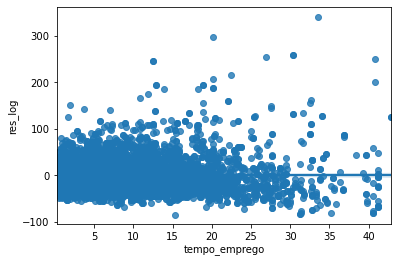

In [230]:
df['res_log'] = step_reg.resid

sns.regplot(x='tempo_emprego', y='res_log', data = df)

In [233]:
ypred = step_reg.predict(X_test)
df['renda_pred'] = ypred
r = df[['renda_pred' , 'renda']].corr().iloc[0,1]
r**2

0.29856940647637725

O melhor resultado foi o da base de treino 

### Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?

O modelo step_reg teve os melhores parametros , com um $R^2$ de 0.351 e com o AIC e BIC reduzidos , comparados aos demais modelos.

### Partindo dos modelos que você ajustou, tente melhorar o  𝑅2  na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.

<AxesSubplot:>

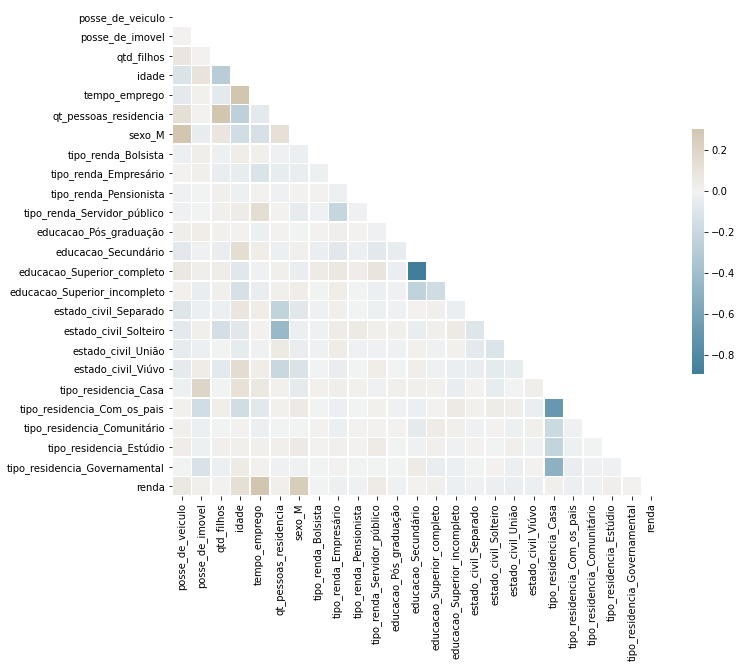

In [131]:
corr = df_train.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 57, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

'np.log(renda) ~ sexo_M + tempo_emprego + tipo_renda_Empresário + idade + educacao_Superior_completo + posse_de_imovel'

In [200]:
modelo = 'np.sqrt(renda) ~ sexo_M + (tempo_emprego)'
step_reg = smf.ols(modelo,data = df_train).fit()
step_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         np.sqrt(renda)   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     2431.
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:20:53   Log-Likelihood:                -44780.
No. Observations:                9320   AIC:                         8.957e+04
Df Residuals:                    9317   BIC:                         8.959e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        38.2798      0.545     70.293      0.000      37.212      39.347
sexo_M           30.0871      0.641     46.902      0.000      28.830      31.345
tempo_emprego     2.6207      0.046     57.431      0.000       2.531       2.710
==============================================================================
Omnibus:                     4309.039   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            47814.051
Skew:                           1.931   Prob(JB):                         0.00
Kurtosis:                      13.403   Cond. No.                         24.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [201]:
ypred = step_reg.predict(X_test)
df['renda_pred'] = ypred
r = df[['renda_pred' , 'renda']].corr().iloc[0,1]
r**2

0.2934008664190282

In [206]:
modelo = 'np.log(renda) ~ sexo_M + (tempo_emprego)'
step_reg = smf.ols(modelo,data = df_train).fit()
step_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     2360.
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:22:21   Log-Likelihood:                -10316.
No. Observations:                9320   AIC:                         2.064e+04
Df Residuals:                    9317   BIC:                         2.066e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.5110      0.013    556.713      0.000       7.485       7.537
sexo_M            0.7685      0.016     48.357      0.000       0.737       0.800
tempo_emprego     0.0620      0.001     54.849      0.000       0.060       0.064
==============================================================================
Omnibus:                        0.475   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.788   Jarque-Bera (JB):                0.448
Skew:                           0.014   Prob(JB):                        0.799
Kurtosis:                       3.018   Cond. No.                         24.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [207]:
ypred = step_reg.predict(X_test)
df['renda_pred'] = ypred
r = df[['renda_pred' , 'renda']].corr().iloc[0,1]
r**2

0.2922816361662305

- Removi as variaveis que não tinham correlacao com renda , pra tentar criar um modelo mais simples , o modelo da raiz quadrada de renda , teve um AIC muito maior que os demais modelos , apesar de ter um r quadrado muito proximo dos outros na base de testes. 
- Testarei abaixo o melhor modelo ate agora(o modelo criado a partir do stepwise) , mas ao invez de log , utilizarei a raiz quadrada tambem.

In [236]:
modelo = 'np.sqrt(renda) ~ sexo_M + tempo_emprego + tipo_renda_Empresário + idade + educacao_Superior_completo + posse_de_imovel'
step_reg = smf.ols(modelo,data = df_train).fit()
step_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         np.sqrt(renda)   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     848.6
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:38:59   Log-Likelihood:                -44705.
No. Observations:                9320   AIC:                         8.942e+04
Df Residuals:                    9313   BIC:                         8.947e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     25.8647      1.516     17.066      0.000      22.894      28.836
sexo_M                        31.0462      0.643     48.276      0.000      29.786      32.307
tempo_emprego                  2.5854      0.048     53.933      0.000       2.491       2.679
tipo_renda_Empresário          5.2151      0.685      7.619      0.000       3.873       6.557
idade                          0.1857      0.035      5.352      0.000       0.118       0.254
educacao_Superior_completo     3.9567      0.630      6.279      0.000       2.721       5.192
posse_de_imovel                2.7787      0.642      4.326      0.000       1.520       4.038
==============================================================================
Omnibus:                     4379.132   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50990.731
Skew:                           1.954   Prob(JB):                         0.00
Kurtosis:                      13.772   Cond. No.                         218.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [237]:
ypred = step_reg.predict(X_test)
df['renda_pred'] = ypred
r = df[['renda_pred' , 'renda']].corr().iloc[0,1]
r**2

0.3006521906720861

- Apesar do AIC alto , consegui aumentar em 1 % o r quadrado na base de testes

### Ajuste uma árvore de regressão e veja se consegue um  𝑅2  melhor com ela.

In [110]:
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [111]:
df = pd.get_dummies(df_raw,drop_first=True)
X = df.drop(axis=1,columns=['renda'])
y = df.renda
X = df[['sexo_M','tempo_emprego','idade','posse_de_imovel','tipo_renda_Empresário','educacao_Superior completo']]

df.posse_de_imovel = df.posse_de_imovel.astype(int)
df.posse_de_veiculo = df.posse_de_veiculo.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [112]:
df

,posse_de_veiculo,posse_de_imovel,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,sexo_M,tipo_renda_Bolsista,tipo_renda_Empresário,...,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,0,1,0,26,6.602740,1.0,8060.34,0,0,1,...,0,0,1,0,0,1,0,0,0,0
1,1,1,0,28,7.183562,2.0,1852.15,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,1,0,35,0.838356,2.0,2253.89,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0,1,1,30,4.846575,3.0,6600.77,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,0,0,33,4.293151,1.0,6475.97,1,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,1,0,0,32,9.849315,2.0,1592.57,1,0,1,...,1,0,0,0,0,1,0,0,0,0
14995,0,1,0,48,13.887671,1.0,7990.58,0,0,1,...,0,0,1,0,0,1,0,0,0,0
14997,1,1,0,45,7.832877,2.0,604.82,0,0,0,...,0,0,0,0,0,1,0,0,0,0
14998,1,0,0,36,4.298630,2.0,3352.27,1,0,1,...,0,0,0,0,0,1,0,0,0,0


n_minimo,2,3,4,5,6,7,8,9,10,11,12,13
profundidade,,,,,,,,,,,,
2,0.250340,0.250340,0.250340,0.250340,0.250340,0.250340,0.250340,0.250340,0.250340,0.250340,0.250340,0.250340
3,0.313532,0.363665,0.363665,0.363665,0.363665,0.363665,0.363665,0.363665,0.363665,0.363665,0.363665,0.363665
4,0.349643,0.378155,0.378155,0.378155,0.375670,0.379736,0.402087,0.403152,0.403952,0.396635,0.397690,0.397690
5,0.368518,0.393012,0.372470,0.371536,0.373532,0.379167,0.401518,0.402827,0.393473,0.390193,0.399810,0.406174
6,0.324070,0.349422,0.344806,0.336412,0.337531,0.340057,0.359570,0.361677,0.348932,0.345680,0.353206,0.359545
7,0.331106,0.322112,0.326224,0.314411,0.322791,0.309461,0.332834,0.354106,0.334648,0.331480,0.343642,0.355810
8,0.288251,0.288370,0.332282,0.324671,0.303129,0.314416,0.337239,0.361389,0.346819,0.343983,0.343754,0.354450


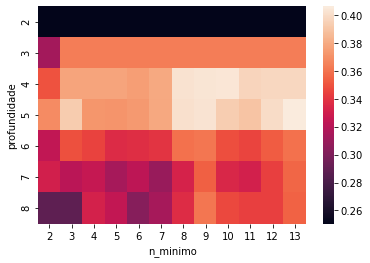

In [113]:
mses = []
ind_i = []
ind_j = []

for i in range(2, 9):
    for j in range(2, 14):
        regr_1 = DecisionTreeRegressor(max_depth=i, min_samples_leaf=j)
        regr_1.fit(X_train, y_train)
        mse1 = regr_1.score(X_test, y_test)
        mses.append(mse1)
        ind_i.append(i)
        ind_j.append(j)
        
df_mse = pd.DataFrame({'mses':mses, 'profundidade':ind_i, 'n_minimo':ind_j})
sns.heatmap(df_mse.pivot(index='profundidade', columns='n_minimo', values='mses'))
a = df_mse.pivot(index='profundidade', columns='n_minimo', values='mses')
a

In [114]:
a.max()

n_minimo
2     0.368518
3     0.393012
4     0.378155
5     0.378155
6     0.375670
7     0.379736
8     0.402087
9     0.403152
10    0.403952
11    0.396635
12    0.399810
13    0.406174
dtype: float64

In [115]:
regr_1 = DecisionTreeRegressor(max_depth=5 , min_samples_leaf=13)


regr_1.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=5, min_samples_leaf=13)

In [116]:
mse1 = regr_1.score(X_train, y_train)


template = "O MSE da árvore com profundidade={0} é: {1:.2f}"

print(template.format(regr_1.get_depth(),mse1).replace(".",","))


O MSE da árvore com profundidade=5 é: 0,46


In [119]:
y_previsto = regr_1.predict(X_test)
print('R² = %s' % metrics.r2_score(y_test, y_previsto).round(3))

R² = 0.406


### Ajustando modelo para log de renda e verificando o R quadrado na base de treino e de teste

n_minimo,2,3,4,5,6,7,8,9,10,11,12
profundidade,,,,,,,,,,,
2,0.285394,0.285394,0.285394,0.285394,0.285394,0.285394,0.285394,0.285394,0.285394,0.285394,0.285394
3,0.354482,0.354482,0.354482,0.354482,0.354482,0.354482,0.354482,0.354482,0.354482,0.354482,0.354482
4,0.369849,0.369849,0.369849,0.369849,0.369849,0.369849,0.369849,0.369849,0.369849,0.369849,0.369849
5,0.372837,0.374474,0.374474,0.374474,0.374474,0.375785,0.375785,0.375785,0.375445,0.375445,0.376165
6,0.372060,0.372437,0.373375,0.376772,0.376801,0.376032,0.374946,0.373575,0.373498,0.373353,0.374063
7,0.371127,0.370638,0.372917,0.369885,0.370125,0.372413,0.370403,0.372200,0.371932,0.371897,0.375725
8,0.360448,0.357880,0.360370,0.355320,0.358155,0.358648,0.357457,0.363570,0.364392,0.368965,0.372679


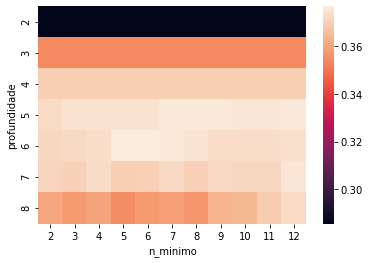

In [120]:
mses = []
ind_i = []
ind_j = []

for i in range(2, 9):
    for j in range(2, 13):
        regr_1 = DecisionTreeRegressor(max_depth=i, min_samples_leaf=j)
        regr_1.fit(X_train, np.log(y_train))
        mse1 = regr_1.score(X_test, np.log(y_test))
        mses.append(mse1)
        ind_i.append(i)
        ind_j.append(j)
        
df_mse = pd.DataFrame({'mses':mses, 'profundidade':ind_i, 'n_minimo':ind_j})
sns.heatmap(df_mse.pivot(index='profundidade', columns='n_minimo', values='mses'))
a = df_mse.pivot(index='profundidade', columns='n_minimo', values='mses')
a

In [121]:
y_train_log = np.log(y_train)

regr_log = DecisionTreeRegressor(max_depth=6 , min_samples_leaf=6)

regr_log.fit(X_train,y_train_log)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=6)

In [122]:
mse1 = regr_log.score(X_train, y_train_log)


template = "O MSE da árvore com profundidade={0} é: {1:.2f}"

print(template.format(regr_log.get_depth(),mse1).replace(".",","))

O MSE da árvore com profundidade=6 é: 0,40


In [123]:
y_previsto = regr_log.predict(X_test)
print('R² = %s' % metrics.r2_score(np.log(y_test), y_previsto).round(3))

R² = 0.377
